In [13]:
# Importing Important libraries
import jax
import numpy as np              # For Scientific Computation
import matplotlib.pyplot as plt # Visualization Library
import jax.numpy as jnp         # For importing jax]
from jax import grad, vmap, jit # For importing Transformation functions
from jax import random
import matplotlib

In [14]:
# Fetching of data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [15]:
# Retrieving features and labels
X = mnist['data']
Y = mnist['target']

In [16]:
# Converting into NumPy array with integer datatype
X = jnp.array(X , dtype = 'int32')
Y = jnp.array(Y , dtype = 'int32')

In [17]:
# #loading data on gpu
if jax.devices("gpu"):
    gpu_device = jax.devices("gpu")[0]
    X = jax.device_put(X, device = gpu_device)
    Y = jax.device_put(Y, device = gpu_device)
else:
    print("No GPU devices found.")

In [18]:
# Reshaping
Y = Y.reshape(1,70000)
X = X.reshape(70000,-1).T
print(X.shape)

(784, 70000)


In [19]:
# Verifying the shape of image
Lets_plot = X[:,60000]
Lets_plot_image = Lets_plot.reshape(28,28)
print(Lets_plot_image.shape)

(28, 28)


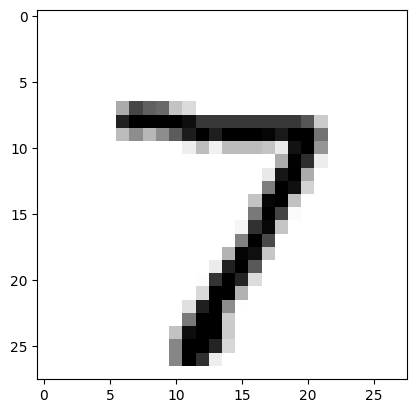

In [20]:
# Plotting any one image to verify the correct fetching of data
plt.imshow(Lets_plot_image, cmap = matplotlib.cm.binary, interpolation = "nearest")

In [21]:
# Label Corresponding to above image
Y[:,60000]

Array([7], dtype=int32)

In [22]:
# Pre-Processing of the data
X_train = X[:,:60000]
X_test  = X[:,60000:]
Y_train = Y[:,:60000]
Y_test  = Y[:,60000:]
X_train = X_train
X_test = X_test
X_train = X_train / 255
X_test = X_test / 255
Y_train.size

60000

In [23]:
# Initialization
def initialize_parameters():
  seed = 0
  key = random.PRNGKey(seed)
  W1 = random.normal(key,(196,784)) * 0.01
  W2 = random.normal(key,(98,196))  * 0.01
  W3 = random.normal(key,(49,98))   * 0.01
  W4 = random.normal(key,(10,49))   * 0.01
  b1 = jnp.zeros((196,1))
  b2 = jnp.zeros((98,1))
  b3 = jnp.zeros((49,1))
  b4 = jnp.zeros((10,1))
  parameters = { "W1": W1, "W2": W2, "W3": W3, "W4": W4, "b1": b1, "b2": b2, "b3": b3, "b4": b4 }
  return parameters
  # Activations
def ReLU(Z):
  return jnp.maximum(Z, 0)

def SoftMax(Z):
  A = jnp.exp(Z) / jnp.sum(jnp.exp(Z), axis = 0, keepdims = True)
  return A

In [24]:
# Forward Propagation
def forward_propagation(params, X):
  W1 = params["W1"]
  W2 = params["W2"]
  W3 = params["W3"]
  W4 = params["W4"]
  b1 = params["b1"]
  b2 = params["b2"]
  b3 = params["b3"]
  b4 = params["b4"]
  Z1 = jnp.dot(W1,X) + b1
  A1 = ReLU(Z1)
  Z2 = jnp.dot(W2,A1) + b2
  A2 = ReLU(Z2)
  Z3 = jnp.dot(W3,A2) + b3
  A3 = ReLU(Z3)
  Z4 = jnp.dot(W4,A3) + b4
  A4 = SoftMax(Z4)
  return Z1, A1, Z2, A2, Z3, A3, Z4, A4

In [25]:
def compute_cost(A4, Y):
  m = Y.size
  cost = -1/m * jnp.sum(Y*jnp.log(A4))
  return cost

In [34]:
def one_hot(Y):
  encoded_array = jnp.zeros((Y.size, Y.max() + 1), dtype = "int32")
  # Jax object does not support item assignment. JAX arrays are immutable. Therefore, we use set method
  encoded_array = encoded_array.at[jnp.arange(Y.size), Y].set(1)
  encoded_array = jnp.transpose(encoded_array)
  return encoded_array

def relu_derivative(Z):
  return Z >= 0

In [27]:
# backward Propagation
def backward_propagation(Z1, A1, Z2, A2, Z3, A3, Z4, A4, W2, W3, W4, X, Y):
  m = Y.size
  dZ4 = A4 - one_hot(Y)
  dW4 = 1/m * jnp.dot(dZ4, jnp.transpose(A3))
  db4 = 1/m * jnp.sum(dZ4, axis =1, keepdims = True)
  dZ3 = np.dot(jnp.transpose(W4), dZ4) * relu_derivative(Z3)
  dW3 = 1/m * jnp.dot(dZ3, jnp.transpose(A2))
  db3 = 1/m * jnp.sum(dZ3, axis =1, keepdims = True)
  dZ2 = jnp.dot(jnp.transpose(W3), dZ3) * relu_derivative(Z2)
  dW2 = 1/m * jnp.dot(dZ2, jnp.transpose(A1))
  db2 = 1/m * jnp.sum(dZ2, axis = 1, keepdims = True)
  dZ1 = jnp.dot(jnp.transpose(W2), dZ2) * relu_derivative(Z1)
  dW1 = 1/m * jnp.dot(dZ1, jnp.transpose(X))
  db1 = 1/m * jnp.sum(dZ1,axis = 1, keepdims = True)
  grads ={ "dW1": dW1, "dW2": dW2, "dW3": dW3, "dW4": dW4, "db1": db1, "db2": db2, "db3": db3, "db4": db4  }
  return grads

In [28]:
def update_parameters(params,grads, Learning_rate):
  parameters = params.copy()

  L = len(parameters)//2

  for l in range(L):
      parameters["W" + str(l+1)] = params["W" + str(l+1)] - Learning_rate*grads["dW" + str(l+1)]
      parameters["b" + str(l+1)] = params["b" + str(l+1)] - Learning_rate*grads["db" + str(l+1)]

  return parameters

In [ ]:
def get_predictions(A2):
  return jnp.argmax(A2, 0)

def get_accuracy(predictions, Y):
  print(predictions, Y)
  return jnp.sum(predictions == Y)/ Y.size

def Gradient_Descent(X, Y, No_Of_Iterations, Learning_Rate):
  parameters = initialize_parameters()

  for i in range(0, No_Of_Iterations):
    Z1, A1, Z2, A2, Z3, A3, Z4, A4 = forward_propagation(parameters, X)
    cost = compute_cost(A4, one_hot(Y))
    grads = backward_propagation(Z1, A1, Z2, A2, Z3, A3, Z4, A4, parameters["W2"], parameters["W3"], parameters["W4"], X, Y)
    parameters = update_parameters(parameters, grads, Learning_Rate)
    if i% 100 == 0:
      print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
    if i % 100 == 0 or i == No_Of_Iterations:
      print("Iterations: " + str(i))
      predictions = get_predictions(A4)
      print("Accuracy  :" + str(get_accuracy(predictions, Y)))
  return parameters, cost

In [39]:
parameters, cost = Gradient_Descent(X_train, Y_train, 5000, 0.2)

Cost after iteration 0: 0.2302585393190384
Iterations: 0
[4 2 2 ... 5 2 5] [[5 0 4 ... 5 6 8]]
Accuracy  :0.081133336
Cost after iteration 100: 0.23011666536331177
Iterations: 100
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
Accuracy  :0.11236667
Cost after iteration 200: 0.23011338710784912
Iterations: 200
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
Accuracy  :0.11236667
Cost after iteration 300: 0.2301119714975357
Iterations: 300
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
Accuracy  :0.11236667
Cost after iteration 400: 0.23011015355587006
Iterations: 400
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
Accuracy  :0.11236667
Cost after iteration 500: 0.23010729253292084
Iterations: 500
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
Accuracy  :0.11236667
Cost after iteration 600: 0.23010241985321045
Iterations: 600
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
Accuracy  :0.11236667
Cost after iteration 700: 0.23009374737739563
Iterations: 700
[1 1 1 ... 1 1 1] [[5 0 4 ... 5 6 8]]
Accuracy  :0.11236667
Cost after iteration 800: 0.2

In [40]:
Z1, A1, Z2, A2, Z3, A3, Z4, A4 = forward_propagation(parameters, X_test)
predictions = get_predictions(A4)
print("Accuracy  :" + str(get_accuracy(predictions, Y_test)))

[7 2 1 ... 4 5 6] [[7 2 1 ... 4 5 6]]
Accuracy  :0.96970004
